# prototyping LSS pipeline

## setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os, pickle, time, glob, sys, copy
import numpy as np 
import scipy
import mdtraj as md 
import MDAnalysis as mda
import nglview as nv 
from ipywidgets import interactive, VBox
import sklearn.preprocessing as pre
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import pyemma as py 
from pyemma.util.contexts import settings
import warnings
warnings.filterwarnings('ignore')

/home/joseph/anaconda3/envs/lss/lib/python3.6/site-packages/Bio/KDTree/__init__.py:25: BiopythonDeprecationWarning: Bio.KDTree has been deprecated, and we intend to remove it in a future release of Biopython. Please use Bio.PDB.kdtrees instead, which is functionally very similar.
  BiopythonDeprecationWarning)
/home/joseph/anaconda3/envs/lss/lib/python3.6/site-packages/MDAnalysis/due.py:88: UserWarning: No module named 'duecredit'
  warnings.warn(str(err))


In [3]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1' 

In [4]:
import tensorflow as tf
import keras.backend as K
from keras.models import load_model
from keras.callbacks import EarlyStopping
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.tensorflow_backend.set_session(tf.Session(config=config))

Using TensorFlow backend.


In [5]:
import sys
#__all__ = ["hde", "propagator", "molgen"]
from hde import *#__init__, hde, propagator, molgen, analysis #

## locating trajectory data

In [6]:
# DESRES Chignolin at 340 K
# Lindorff-Larsen et al. Science 334 6055 517-520 (2011)
# 200 ps time steps
# 53 dcd files each conataining 10,000 frames at 200 ps time steps = 53*10,000*200 = 106 us

timestep = 200 # ps

pdb_dir = "/media/joseph/Memorex USB/liew/Joe_Liew_LSS/Joe_Liew_LSS/BBA/3_DESRES-Trajectory_1FME-1-protein/DESRES-Trajectory_1FME-1-protein/1FME-1-protein"
pdb_file = os.path.join(pdb_dir, "system.pdb")

trj_dir = pdb_dir
trj_file = []
for i in np.arange(0,10):
    fname = "1FME-1-protein-" + str(i).zfill(3) + ".dcd"
    trj_file.append(os.path.join(trj_dir, fname))
print(pdb_file)

print(pdb_file)
view = nv.show_structure_file(pdb_file)
view.clear_representations()
view.add_ball_and_stick()
view

/media/joseph/Memorex USB/liew/Joe_Liew_LSS/Joe_Liew_LSS/BBA/3_DESRES-Trajectory_1FME-1-protein/DESRES-Trajectory_1FME-1-protein/1FME-1-protein/system.pdb
/media/joseph/Memorex USB/liew/Joe_Liew_LSS/Joe_Liew_LSS/BBA/3_DESRES-Trajectory_1FME-1-protein/DESRES-Trajectory_1FME-1-protein/1FME-1-protein/system.pdb


NGLWidget()

### mdtraj load and view

In [8]:
traj_obj = md.load(trj_file, top=pdb_file)

In [9]:
traj_obj.center_coordinates(mass_weighted=False)
traj_obj.superpose(traj_obj[0])

<mdtraj.Trajectory with 100000 frames, 504 atoms, 28 residues, and unitcells at 0x7f9adcfaa518>

In [10]:
view = nv.show_mdtraj(traj_obj)
view.clear_representations()
view.add_spacefill()
view

NGLWidget(count=100000)

#### h2t

In [11]:
Ca_first_idx = traj_obj.topology.select('name CA and resid 0')
Ca_last_idx = traj_obj.topology.select('name CA and resid ' + str(traj_obj.n_residues-1))

In [12]:
h2t = md.compute_distances(traj_obj, np.reshape(np.array([Ca_first_idx, Ca_last_idx]), (1,2)), periodic=True, opt=True)

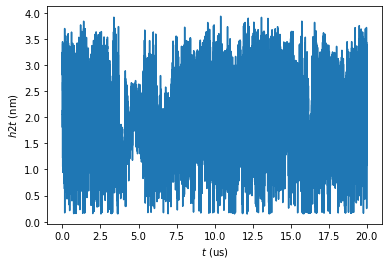

In [13]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(h2t))*timestep/1E6, h2t)
ax.set_xlabel("$t$ (us)")
ax.set_ylabel("$h2t$ (nm)")
plt.show()

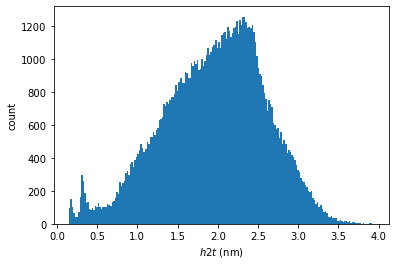

In [14]:
fig, ax = plt.subplots()
_ = plt.hist(h2t, bins=200)
ax.set_ylabel("count")
ax.set_xlabel("$h2t$ (nm)")
plt.show()

#### RMSD

In [15]:
view = nv.show_mdtraj(traj_obj[25000])
view.clear_representations()
view.add_spacefill()
view

NGLWidget()

In [16]:
rmsd = md.rmsd(traj_obj,traj_obj[25000],0)

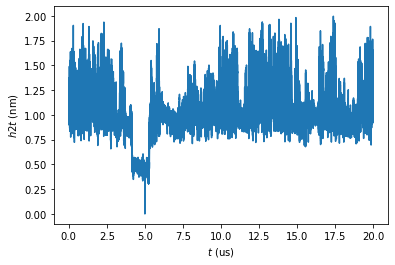

In [17]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(h2t))*timestep/1E6, rmsd)
ax.set_xlabel("$t$ (us)")
ax.set_ylabel("$h2t$ (nm)")
plt.show()

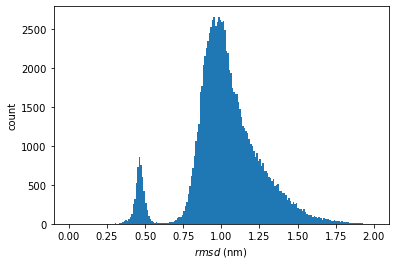

In [18]:
fig, ax = plt.subplots()
_ = plt.hist(rmsd, bins=200)
ax.set_ylabel("count")
ax.set_xlabel("$rmsd$ (nm)")
plt.show()

#### dihedrals

## featurization

In [19]:
# featurizing
features = py.coordinates.featurizer(pdb_file)
features.add_backbone_torsions(cossin=True)
features.add_sidechain_torsions(which='all', cossin=True)
atom_idx = features.select_Backbone() # select_Heavy() select_Ca()
features.add_inverse_distances(atom_idx)

#print(features.describe())
print('dim = %d' % features.dimension())

11-03-21 12:55:43 pyemma.coordinates.data.featurization.featurizer.MDFeaturizer[0] WARNING  The 1D arrays input for add_inverse_distances() have been sorted, and index duplicates have been eliminated.
Check the output of describe() to see the actual order of the features
dim = 3744


/home/joseph/anaconda3/envs/lss/lib/python3.6/site-packages/mdtraj/geometry/dihedral.py:374: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  indices = np.vstack(x for x in indices if x.size)[id_sort]
/home/joseph/anaconda3/envs/lss/lib/python3.6/site-packages/pyemma/coordinates/data/featurization/angles.py:211: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  indices = np.vstack(valid.values())


In [20]:
data = np.zeros((0,features.dimension()))
for i in range(len(trj_file)):
    q = py.coordinates.load(trj_file[i], features=features)
    data = np.concatenate((data,q), axis=0)
    print(i)
    print(data.shape)

0
(10000, 3744)
1
(20000, 3744)
2
(30000, 3744)
3
(40000, 3744)
4
(50000, 3744)
5
(60000, 3744)
6
(70000, 3744)
7
(80000, 3744)
8
(90000, 3744)
9
(100000, 3744)


## (1) latent space projection

### parameters

In [21]:
lag=50
dim=2
is_reversible=True

### SRV

In [22]:
#earlyStopping = EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='min', restore_best_weights=True)

hde = HDE(
    features.dimension(), 
    n_components=dim, 
    lag_time=lag,
    reversible=is_reversible, 
    n_epochs=300,
    learning_rate=0.0005,
    hidden_layer_depth=2,
    hidden_size=100,
    activation='tanh', 
    batch_size=20000,
    batch_normalization=True,
    #callbacks=[earlyStopping], 
    verbose=True
)

In [23]:
hde = pickle.load(open('hde.pkl', 'rb'))

/home/joseph/anaconda3/envs/lss/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [24]:
hde_coords = hde.transform(data, side='left')
hde_coords_right = hde.transform(data, side='right')
hde_timescales = hde.timescales_
print(hde_timescales)
print(hde_coords)
print(hde.eigenvalues_)


[100192.77672892  87384.97221223]
[[0.03042117 0.40678477]
 [0.02703582 0.4053782 ]
 [0.02603021 0.4063523 ]
 ...
 [0.03442994 0.40699023]
 [0.03532997 0.4073636 ]
 [0.03807956 0.40848562]]
[0.99950109 0.99942798]


Text(0.5, 1.0, "$t_i$'s BBA")

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


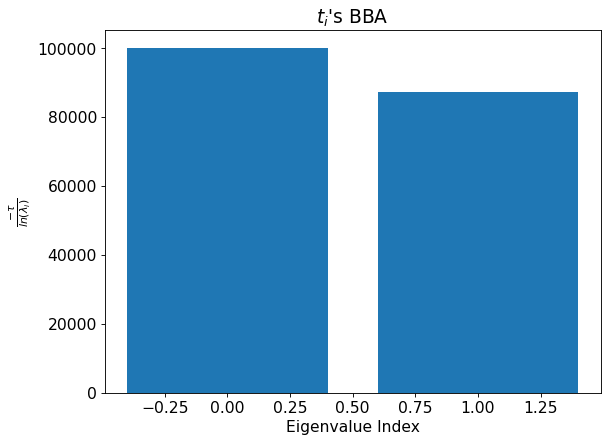

In [25]:
from matplotlib.pyplot import figure
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

heights = -lag/np.log(hde.eigenvalues_)
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.bar(range(len(heights)), heights)
plt.xlabel("Eigenvalue Index")
plt.ylabel(r'$\frac{-\tau}{ln(\lambda_i)}$')
plt.title(r"$t_i$'s BBA")

<function matplotlib.pyplot.show(*args, **kw)>

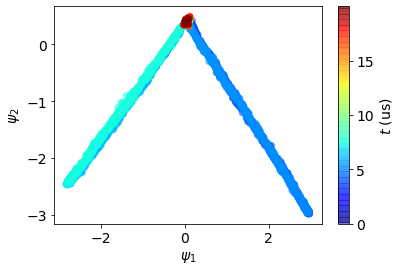

In [26]:
# 2D scatterplot
fig, ax = plt.subplots()
im = ax.scatter(hde_coords[:,0],hde_coords[:,1], c=np.arange(hde_coords.shape[0])*timestep/1E6, alpha=0.5, cmap='jet')
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$\psi_2$')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'$t$ (us)')
plt.show

IndexError: index 2 is out of bounds for axis 1 with size 2

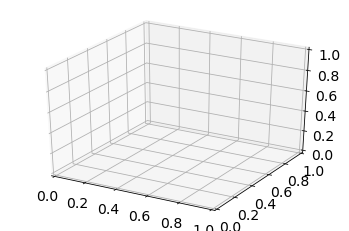

In [27]:
# 3D scatterplot
fig = plt.figure()
ax = fig.gca(projection="3d")
im = ax.scatter(hde_coords[:, 0], hde_coords[:, 1], hde_coords[:, 2], c=np.arange(hde_coords.shape[0])*timestep/1E6, alpha=0.5, cmap='jet')
ax.set_xlabel(r'$\psi_1$')
ax.set_ylabel(r'$\psi_2$')
ax.set_zlabel(r'$\psi_3$')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'$t$ (us)')
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

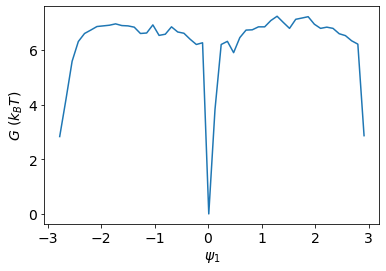

In [28]:
# 1D PMF
pdf, bin_edges = np.histogram(hde_coords[:,0], bins=50, density=True)
bin_mids = bin_edges[:-1]+0.5*(bin_edges[1]-bin_edges[0])
pmf = -np.log(pdf)
pmf -= min(pmf)
fig, ax = plt.subplots()
im = ax.plot(bin_mids, pmf)
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$G$ ($k_BT$)')
plt.show

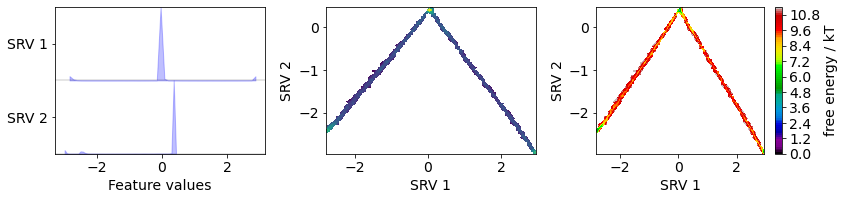

In [29]:
# pyemma distributions
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
py.plots.plot_feature_histograms(
    hde_coords, ['SRV {}'.format(i + 1) for i in range(dim)], ax=axes[0])
py.plots.plot_density(*hde_coords[:, :2].T, ax=axes[1], cbar=False, logscale=True)
py.plots.plot_free_energy(*hde_coords[:, :2].T, ax=axes[2], legacy=False)
for ax in axes.flat[1:]:
    ax.set_xlabel('SRV 1')
    ax.set_ylabel('SRV 2')
fig.tight_layout()

In [30]:
def plot_its(lags, its, its_stderr, dim, data_name, ax, marker='o'):

    for i in range(dim):
        ax.plot(lags,its[:,i].flatten(), marker=marker, label=data_name + ' $t$' + str(i))
        ax.fill_between(lags, its[:,i].flatten() - its_stderr[:,i].flatten(), its[:,i].flatten() + its_stderr[:,i].flatten(), alpha=0.2)
    ax.plot(lags, lags, linewidth=2, color='black')
    ax.fill_between(lags, 1e-3*np.ones(len(lags)), lags, alpha=0.5, color='grey')
    ax.set_xlim([np.min(lags), np.max(lags)])
    ax.set_ylim(ymin = np.min(lags))
    ax.set_yscale('log')
    ax.legend(loc='lower right')

2


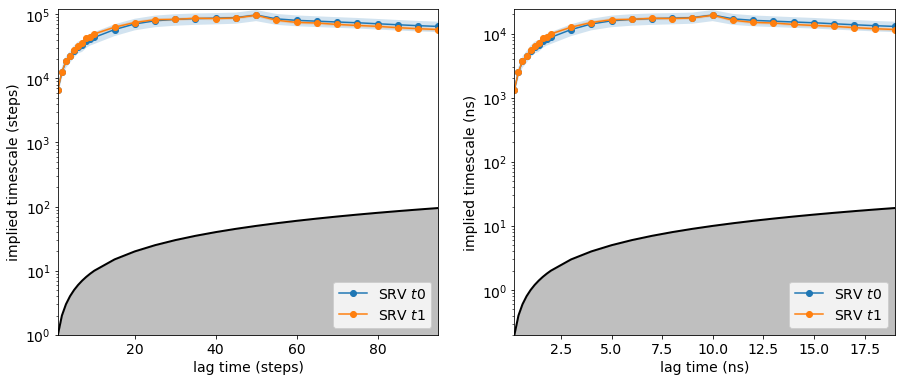

In [31]:
# implied time scales
lags = np.concatenate((np.arange(1,10,1), np.arange(10,100,5)))

its = analysis.generate_its(hde_coords, lags)
print(dim)
its_CV = []
n_blocks=5
for i in range(n_blocks):
    its_CV_i = analysis.generate_its(np.array_split(hde_coords,n_blocks,axis=0)[i], lags)
    its_CV.append(its_CV_i)
its_CV = np.array(its_CV)
its_stderr = np.std(its_CV, axis=0)/np.sqrt(n_blocks)

fig, ax = plt.subplots(1, 2, figsize=(15,6))
plot_its(lags, its, its_stderr, dim, 'SRV', ax[0])
ax[0].set_xlabel('lag time (steps)')
ax[0].set_ylabel('implied timescale (steps)')

plot_its(lags*timestep/1E3, its*timestep/1E3, its_stderr*timestep/1E3, dim, 'SRV', ax[1])
ax[1].set_xlabel('lag time (ns)')
ax[1].set_ylabel('implied timescale (ns)')

plt.show()

its_SRV = copy.deepcopy(its)
its_SRV_stderr = copy.deepcopy(its_stderr)

### tICA

In [32]:
tica = py.coordinates.tica(data, dim=dim, lag=lag)
tica_coords = tica.get_output()[0]
print(tica.timescales[:dim])
print(tica_coords)

calculate covariances:   0%|          | 0/12 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/12 [00:00<?, ?it/s]

[11872.98477654  7316.33726596]
[[-0.17876714 -0.4374765 ]
 [-0.17780964 -0.34405607]
 [-0.25686252 -0.3589689 ]
 ...
 [-0.17853133 -0.2730382 ]
 [-0.17795582 -0.2746653 ]
 [-0.14679106 -0.31900603]]


<function matplotlib.pyplot.show(*args, **kw)>

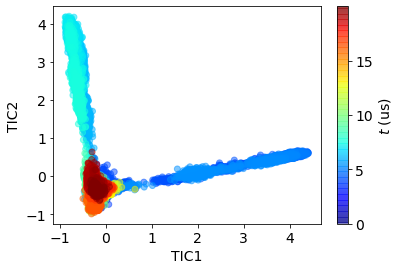

In [33]:
# 2D scatterplot
fig, ax = plt.subplots()
im = ax.scatter(tica_coords[:,0], tica_coords[:,1], c=np.arange(tica_coords.shape[0])*timestep/1E6, alpha=0.5, cmap='jet')
plt.xlabel('TIC1')
plt.ylabel('TIC2')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'$t$ (us)')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

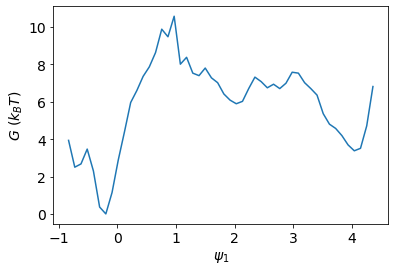

In [35]:
# 1D PMF
pdf, bin_edges = np.histogram(tica_coords[:,0], bins=50, density=True)
bin_mids = bin_edges[:-1]+0.5*(bin_edges[1]-bin_edges[0])
pmf = -np.log(pdf)
pmf -= min(pmf)
fig, ax = plt.subplots()
im = ax.plot(bin_mids, pmf)
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$G$ ($k_BT$)')
plt.show

getting output of TICA:   0%|          | 0/12 [00:00<?, ?it/s]

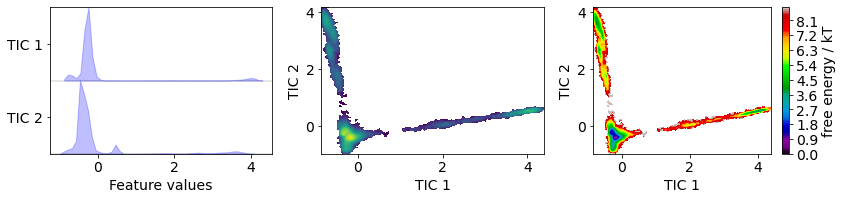

In [37]:
# pyemma distributions
tica_concatenated = np.concatenate(tica.get_output())

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
py.plots.plot_feature_histograms(
    tica_concatenated, ['TIC {}'.format(i + 1) for i in range(tica.dimension())], ax=axes[0])
py.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], cbar=False, logscale=True)
py.plots.plot_free_energy(*tica_concatenated[:, :2].T, ax=axes[2], legacy=False)
for ax in axes.flat[1:]:
    ax.set_xlabel('TIC 1')
    ax.set_ylabel('TIC 2')
fig.tight_layout()

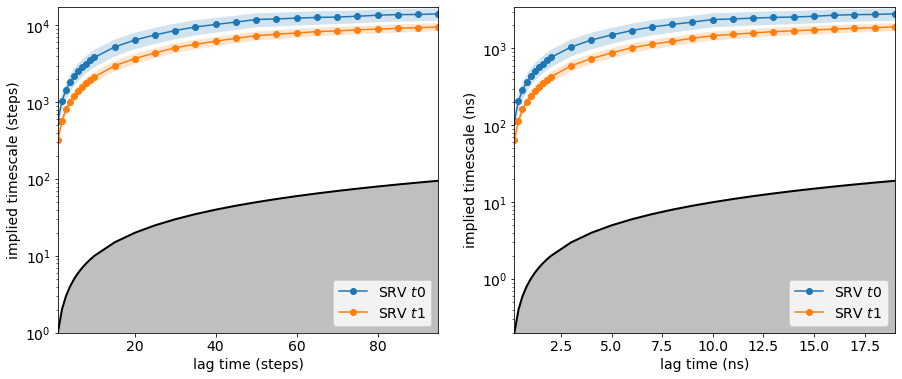

In [38]:
# implied time scales
lags = np.concatenate((np.arange(1,10,1), np.arange(10,100,5)))

its = analysis.generate_its(tica_coords, lags)

its_CV = []
n_blocks=5
for i in range(n_blocks):
    its_CV_i = analysis.generate_its(np.array_split(tica_coords,n_blocks,axis=0)[i], lags)
    its_CV.append(its_CV_i)
its_CV = np.array(its_CV)
its_stderr = np.std(its_CV, axis=0)/np.sqrt(n_blocks)

fig, ax = plt.subplots(1, 2, figsize=(15,6))
plot_its(lags, its, its_stderr, dim, 'SRV', ax[0])
ax[0].set_xlabel('lag time (steps)')
ax[0].set_ylabel('implied timescale (steps)')

plot_its(lags*timestep/1E3, its*timestep/1E3, its_stderr*timestep/1E3, dim, 'SRV', ax[1])
ax[1].set_xlabel('lag time (ns)')
ax[1].set_ylabel('implied timescale (ns)')

plt.show()

its_TICA = copy.deepcopy(its)
its_TICA_stderr = copy.deepcopy(its_stderr)

### SRVs vs. tICA implied time scales

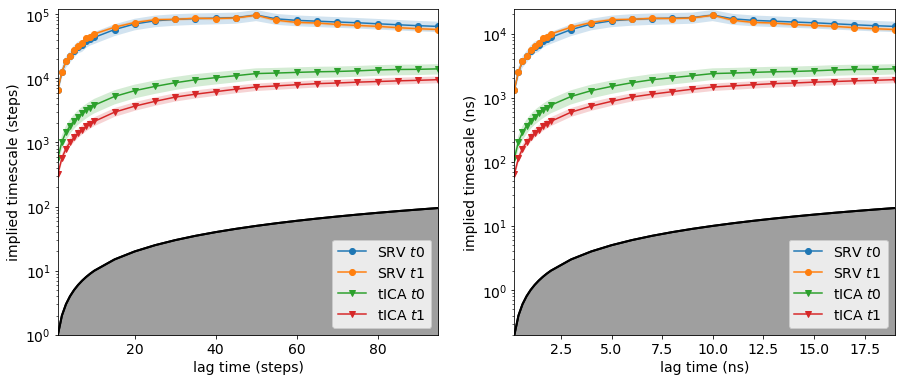

In [39]:
# implied time scales: SRVs vs. tICA

fig, ax = plt.subplots(1, 2, figsize=(15,6))
plot_its(lags, its_SRV, its_SRV_stderr, dim, 'SRV', ax[0])
ax[0].set_xlabel('lag time (steps)')
ax[0].set_ylabel('implied timescale (steps)')
plot_its(lags, its_TICA, its_TICA_stderr, dim, 'tICA', ax[0], marker='v')

plot_its(lags*timestep/1E3, its_SRV*timestep/1E3, its_SRV_stderr*timestep/1E3, dim, 'SRV', ax[1])
ax[1].set_xlabel('lag time (ns)')
ax[1].set_ylabel('implied timescale (ns)')
plot_its(lags*timestep/1E3, its_TICA*timestep/1E3, its_TICA_stderr*timestep/1E3, dim, 'tICA', ax[1], marker='v')

plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

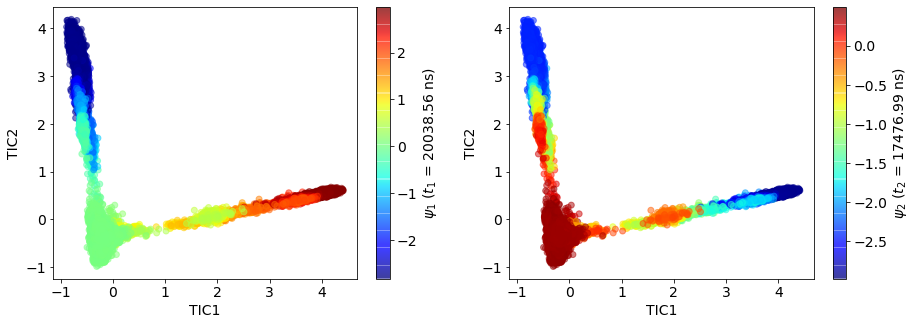

In [40]:
# 2D scatterplot
fig, ax = plt.subplots(1,2,figsize=(15,5))

im = ax[0].scatter(tica_coords[:,0], tica_coords[:,1], c=hde_coords[:,0], alpha=0.5, cmap='jet')
cbar = fig.colorbar(im, ax=ax[0])
cbar.set_label(r'$\psi_1$ ($t_1$ = ' + str(np.round(hde_timescales[0]*timestep/1E3,2)) + ' ns)')
ax[0].set_xlabel('TIC1')
ax[0].set_ylabel('TIC2')

im = ax[1].scatter(tica_coords[:,0], tica_coords[:,1], c=hde_coords[:,1], alpha=0.5, cmap='jet')
cbar = fig.colorbar(im, ax=ax[1])
cbar.set_label(r'$\psi_2$ ($t_2$ = ' + str(np.round(hde_timescales[1]*timestep/1E3,2)) + ' ns)')
ax[1].set_xlabel('TIC1')
ax[1].set_ylabel('TIC2')

plt.show

### kernel TICA

### SRV k-means clustering

#### n_cluster optimization using silhouette score

- expect n_cluster = (dim_kmeans+1) similar to PCCA (# macrostates = 1 + # singular vectors)

- Idea of inner simplex (PCCA) clustering directly in singular vectors of transfer operator:
F. Paul, H. Wu, M. Vossel, B.L. de Groot, and F. Noe "Identification of kinetic order parameters
for non-equilibrium dynamics" J. Chem. Phys. 150, 164120 (2019); doi: 10.1063/1.5083627

- k-means simpler and only for understanding of macrostates not construction of MSM

In [41]:
dim_kmeans = 2
hde_coords_kmeans = copy.deepcopy(hde_coords[:,:dim_kmeans])

In [42]:
range_n_clusters = np.arange(2,5,1)
silhouette_avg_array = []

for n_clusters in range_n_clusters:
    
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=200184)
    cluster_labels = clusterer.fit_predict(hde_coords_kmeans)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(hde_coords_kmeans, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    silhouette_avg_array.append(silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.8730869


KeyboardInterrupt: 

In [ ]:
n_clusters = dim_kmeans+1 # usually, but check silhouette scores

In [ ]:
clusterer = KMeans(n_clusters=n_clusters, random_state=10)
cluster_labels = clusterer.fit_predict(hde_coords_kmeans)
centers = clusterer.cluster_centers_
sample_silhouette_values = silhouette_samples(hde_coords_kmeans, cluster_labels)

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(6,6))

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
im1 = ax1.scatter(hde_coords_kmeans[:, 0], hde_coords_kmeans[:, 1], marker='.', s=30, lw=0, alpha=0.7,
            c=colors, edgecolor='k')

# Labeling the clusters
# Draw white circles at cluster centers
ax1.scatter(centers[:, 0], centers[:, 1], marker='o',
            c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax1.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                s=50, edgecolor='k')

ax1.set_xlabel("$\psi_1$")
ax1.set_ylabel("$\psi_2$")

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
im2 = ax2.scatter(hde_coords_kmeans[:, 0], hde_coords_kmeans[:, 1], marker='.', s=30, lw=0, alpha=0.7,
            c=sample_silhouette_values, edgecolor='k')

# Labeling the clusters
centers = clusterer.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
            c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                s=50, edgecolor='k')

ax2.set_xlabel("$\psi_1$")
ax2.set_ylabel("$\psi_2$")
cbar = fig.colorbar(im2, ax=ax2)
cbar.set_label('silhouette score')

plt.show()

#### visualizing configs proximate to k-means centers

In [ ]:
centers

In [ ]:
kmeans_viz = []
for i in range(n_clusters):
    idx_sort = np.argsort(np.sqrt(np.sum((hde_coords_kmeans - centers[i,:])**2, axis=1)))
    kmeans_viz.append(idx_sort[:10])

In [ ]:
for i in range(n_clusters):
    print(hde_coords_kmeans[kmeans_viz[i][0],:])

In [ ]:
clust_id = 0
view = nv.NGLWidget()
for k in range(len(kmeans_viz[clust_id])):
    view.add_trajectory(traj_obj[kmeans_viz[clust_id][k]])
view

In [ ]:
clust_id = 1
view = nv.NGLWidget()
for k in range(len(kmeans_viz[clust_id])):
    view.add_trajectory(traj_obj[kmeans_viz[clust_id][k]])
view

In [ ]:
clust_id = 2
view = nv.NGLWidget()
for k in range(len(kmeans_viz[clust_id])):
    view.add_trajectory(traj_obj[kmeans_viz[clust_id][k]])
view

In [ ]:
view = nv.NGLWidget()
view.add_trajectory(traj_obj[kmeans_viz[0][0]])
view.component_0.clear_representations()
view.component_0.add_cartoon(color='blue', opacity=0.8)
view.add_trajectory(traj_obj[kmeans_viz[1][0]])
view.component_1.clear_representations()
view.component_1.add_cartoon(color='red', opacity=0.8)
view.add_trajectory(traj_obj[kmeans_viz[2][0]])
view.component_2.clear_representations()
view.component_2.add_cartoon(color='green', opacity=0.8)
view

## (2) propagator

In [43]:
dim_prop = 2

In [44]:
traj_prop = copy.deepcopy(hde_coords[:,:dim_prop])

In [45]:
prop_scaler = pre.MinMaxScaler(feature_range=(0,1))
if dim_prop==1:
    traj_prop_scaled = prop_scaler.fit_transform(traj_prop.reshape(-1, 1))
else:
    traj_prop_scaled = prop_scaler.fit_transform(traj_prop)

In [47]:
n_mix = 25
lag_prop = lag
lr_prop = 0.0001

In [48]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50, restore_best_weights=True)
]

In [49]:
prop = Propagator(
    traj_prop_scaled.shape[1], 
    n_components=n_mix, 
    lag_time=lag_prop, 
    batch_size=200000, 
    learning_rate=lr_prop, 
    n_epochs=20000,
    callbacks=callbacks,
    hidden_size=100,
    activation='relu'
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
The `logits` property will return `None` when the distribution is parameterized with `logits=None`. Use `logits_parameter()` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



In [50]:
from hde.propagator import get_mixture_loss_func

In [51]:
prop.model.compile(loss=get_mixture_loss_func(prop.input_dim, prop.n_components), optimizer=tf.keras.optimizers.Adam(lr=lr_prop))

In [52]:
prop.model.set_weights(pickle.load(open('prop_weights.pkl', 'rb')))

In [53]:
n_steps = np.int(np.floor(np.float(hde_coords.shape[0])/np.float(lag_prop)))
n_traj = 10
synth_trajs_scaled = [prop.propagate(traj_prop_scaled[0].reshape(1,-1).astype(np.float32), n_steps).reshape(n_steps, -1) for item in range(n_traj)]
synth_trajs = [prop_scaler.inverse_transform(synth_trajs_scaled[i]) for i in range(n_traj)]

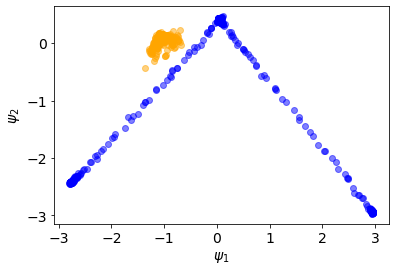

In [54]:
synth_traj_id = 0
fig, ax = plt.subplots()

if dim_prop==1:
    ax.scatter(hde_coords[::lag_prop,0], np.zeors(hde_coords[::lag_prop,0].shape[0]), c='blue', alpha=0.5, cmap='jet')
    ax.scatter(synth_trajs[synth_traj_id][:,0], np.zeros(synth_trajs[synth_traj_id][:,0].shape[0]), c='orange', alpha=0.5, cmap='jet')
    ax.set_xlabel(r'$\psi_1$')
    ax.set_ylabel(r'$\psi_2$')
else:
    ax.scatter(hde_coords[::lag_prop,0], hde_coords[::lag_prop,1], c='blue', alpha=0.5, cmap='jet')
    ax.scatter(synth_trajs[synth_traj_id][:,0], synth_trajs[synth_traj_id][:,1], c='orange', alpha=0.5, cmap='jet')
    ax.set_xlabel(r'$\psi_1$')
    ax.set_ylabel(r'$\psi_2$')

plt.show()

No handles with labels found to put in legend.


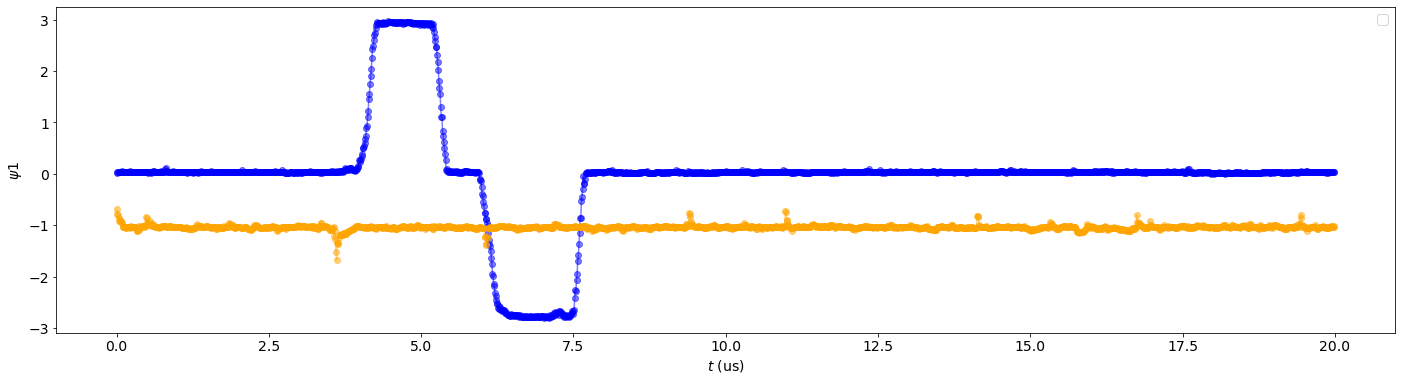

In [57]:
synth_traj_id = 1
psi_id = 0

fig, ax = plt.subplots(figsize=(24, 6))
ax.plot(np.arange(hde_coords[::lag_prop,psi_id].shape[0])*timestep/1E6*lag_prop, hde_coords[::lag_prop,psi_id], color='blue', alpha=0.5, marker='o')
ax.plot(np.arange(synth_trajs[synth_traj_id].shape[0])*timestep/1E6*lag_prop, synth_trajs[synth_traj_id][:,psi_id], color='orange', alpha=0.5, marker='o')
ax.set_xlabel(r'$t$ (us)')
ax.set_ylabel(r'$\psi$'+str(psi_id+1))
plt.legend()
plt.show()

## (3) generator

#### x_train = scaled latent space coordinates

In [58]:
x_train = traj_prop_scaled

#### y_train = aligned molecular configurations

In [59]:
ca_idx = traj_obj.top.select_atom_indices('alpha')
traj_ca = traj_obj.atom_slice(ca_idx)

In [60]:
traj_ca.superpose(traj_ca[0])

<mdtraj.Trajectory with 100000 frames, 28 atoms, 28 residues, and unitcells at 0x7f9aac194da0>

In [61]:
view = nv.show_mdtraj(traj_ca[::lag_prop])
#view.component_0.clear_representations()
view.component_0.add_ribbon(color='blue', opacity=0.6)
view
view

NGLWidget(count=2000)

In [62]:
xyz = traj_ca.xyz.reshape(-1, traj_ca.n_atoms*3)

In [63]:
xyz_scaler = pre.MinMaxScaler(feature_range=(-1,1))

In [64]:
y_train = xyz_scaler.fit_transform(xyz)

In [65]:
n_atoms = traj_ca.n_atoms

#### training cWGAN

In [66]:
molgen = MolGen(
    latent_dim=x_train.shape[1],
    output_dim=y_train.shape[1],
    batch_size=30000,
    noise_dim=50,
    n_epochs=2500,
    hidden_layer_depth=2,
    hidden_size=200,
    n_discriminator=5
)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 200)               10600     
_________________________________________________________________
dense_5 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_6 (Dense)              (None, 84)                16884     
Total params: 67,684
Trainable params: 67,684
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 200)               17400     
_________________________________________________________________
dense_8 (Dense)              (None, 200)               40200     
_________________________________________________________________
dense_

In [67]:
def swish(x):
    return (K.sigmoid(x) * x)
molgen.generator = tf.keras.models.load_model('molgen_generator.h5', custom_objects={'swish': swish},compile=False)
molgen.discriminator = tf.keras.models.load_model('molgen_discriminator.h5', custom_objects={'swish': swish},compile=False)
molgen.is_fitted = True# need to override after loading to allow molgen.transform to proceed


#### decoding synthetic propagator trajectories

In [68]:
assert molgen.is_fitted == True
print(len(synth_trajs_scaled[synth_traj_id]))

2000


In [69]:
synth_traj_id = 1
xyz_synth = xyz_scaler.inverse_transform(molgen.transform(synth_trajs_scaled[synth_traj_id])).reshape(-1, n_atoms, 3)
xyz_synth

array([[[-6.6814905e-01, -3.0929491e-01, -2.3429441e-01],
        [-7.5782096e-01, -2.8989032e-01, -1.4041463e-01],
        [-5.3958333e-01, -2.4404819e-01, -2.7032724e-01],
        ...,
        [-6.3545696e-02,  1.0627832e+00, -9.0204829e-01],
        [-2.1102197e-01,  1.2374195e+00, -9.2348415e-01],
        [-1.6603743e-01,  1.0865258e+00, -1.0854347e+00]],

       [[-6.4262861e-01,  2.9385903e-01,  3.2773277e-01],
        [-6.6752738e-01,  2.0647083e-01, -2.0865085e-02],
        [-6.3761830e-01,  2.5208384e-01,  1.3799345e-01],
        ...,
        [ 3.1977916e-01,  8.0073279e-01, -9.7026688e-01],
        [ 2.1247770e-01,  1.1264416e+00, -9.3655258e-01],
        [ 5.0331014e-01,  1.5525004e+00, -1.0762776e+00]],

       [[-1.0250336e+00, -1.2426515e+00, -7.3505557e-01],
        [-9.3217289e-01, -9.3263292e-01, -4.8882854e-01],
        [-8.0738795e-01, -6.3540488e-01, -5.4641384e-01],
        ...,
        [ 1.5989402e-01,  5.2233773e-01, -5.0798774e-01],
        [ 1.0018898e+00,  5.7

In [70]:
with open('synth.xyz', 'w') as f:
    for i in range(xyz_synth.shape[0]):
        f.write('%d\n' % n_atoms)
        f.write('\n')
        for k in range(n_atoms):
            f.write('%3s%17.9f%17.9f%17.9f\n' % ('C', xyz_synth[i][k][0]*10, xyz_synth[i][k][1]*10, xyz_synth[i][k][2]*10) ) # nm to Angstroms for xyz write

In [71]:
traj_ca[0].save_pdb('synth.pdb')

In [72]:
traj_ca_synth = copy.deepcopy(traj_ca)

In [73]:
traj_ca_synth

<mdtraj.Trajectory with 100000 frames, 28 atoms, 28 residues, and unitcells at 0x7f9adc26e390>

In [74]:
traj_synth_obj = md.load('synth.xyz', top='synth.pdb')

In [75]:
traj_synth_obj.center_coordinates(mass_weighted=False)
traj_synth_obj.superpose(traj_synth_obj[0])

<mdtraj.Trajectory with 2000 frames, 28 atoms, 28 residues, without unitcells at 0x7f9b1b55ab38>

In [76]:
view = nv.show_mdtraj(traj_synth_obj)
view.component_0.clear_representations()
view.component_0.add_ribbon(color='red', opacity=0.6)
view

NGLWidget(count=2000)

## (4) comparison

### thermodynamics (FES)

1D PMF in leading SRV coordinate

adding one pseudo-count to each bin as regularization and avoiding infinite free energies


In [77]:
# MD 1D PMF mean
n_bins = 50
pdf_MD, bin_edges = np.histogram(hde_coords[:,0], bins=n_bins, density=True)
bin_mids = bin_edges[:-1]+0.5*(bin_edges[1]-bin_edges[0])

pdf_MD += 1./(len(hde_coords[:,0])*(bin_edges[1]-bin_edges[0])) # adding one pseudo-count per bin
pmf_MD = -np.log(pdf_MD)
pmf_MD -= np.mean(pmf_MD[np.isfinite(pmf_MD)]) # optimal mutual least squares alignment

In [78]:
# MD 1D PMF block averages
pmf_MD_block = []
n_blocks=5
for i in range(n_blocks):
    
    data_i = np.array_split(hde_coords[:,0],n_blocks,axis=0)[i] #block splits
    
    pdf_MD_i, _ = np.histogram(data_i, bins=bin_edges, density=True)
    pdf_MD_i += 1./(len(data_i)*(bin_edges[1]-bin_edges[0])) # adding one pseudo-count per bin
    
    pmf_MD_i = -np.log(pdf_MD_i)
    pmf_MD_i -= np.mean(pmf_MD_i[np.isfinite(pmf_MD_i)]) # optimal mutual least squares alignment
    pmf_MD_block.append(pmf_MD_i)
    
pmf_MD_block = np.array(pmf_MD_block)
pmf_MD_stderr = np.std(pmf_MD_block, axis=0)/np.sqrt(n_blocks)

In [79]:
# shifting global minimum to zero of optimally least squares aligned landscapes
PMF_shift = min(pmf_MD)
pmf_MD -= PMF_shift
for i in range(n_blocks):
    pmf_MD_block[i] -= PMF_shift

<function matplotlib.pyplot.show(*args, **kw)>

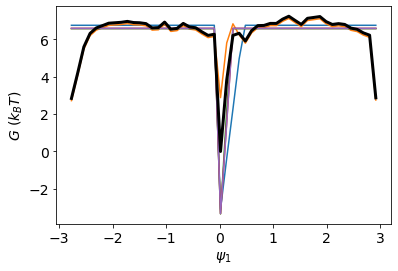

In [80]:
# plotting full and block PMFs
fig, ax = plt.subplots()
for i in range(n_blocks):
    ax.plot(bin_mids, pmf_MD_block[i])
im = ax.plot(bin_mids, pmf_MD, color='black', linewidth=3)
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$G$ ($k_BT$)')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

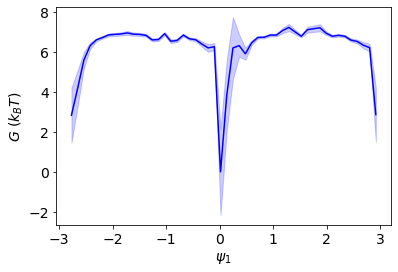

In [81]:
# plotting full PMFs with 95% CI (1.96 standard deviations in standard error)
fig, ax = plt.subplots()
ax.plot(bin_mids, pmf_MD, color='blue')
ax.fill_between(bin_mids, pmf_MD-1.96*pmf_MD_stderr, pmf_MD+1.96*pmf_MD_stderr, alpha=0.2, color='blue')
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$G$ ($k_BT$)')
plt.show

In [82]:
# LSS 1D PMF mean
synth_trajs_CONCAT = np.zeros((0,))
for i in range(n_traj):
    synth_trajs_CONCAT = np.concatenate((synth_trajs_CONCAT,synth_trajs[i][:,0]), axis=0)
pdf_LSS, _ = np.histogram(synth_trajs_CONCAT, bins=n_bins, density=True)

pdf_LSS += 1./(len(synth_trajs_CONCAT)*(bin_edges[1]-bin_edges[0])) # adding one pseudo-count per bin
pmf_LSS = -np.log(pdf_LSS)
pmf_LSS -= np.mean(pmf_LSS[np.isfinite(pmf_LSS)]) # optimal mutual least squares alignment

In [86]:
# LSS 1D PMF block averages
pmf_LSS_block = []
n_blocks=5
for i in range(n_blocks):
    
    data_i = np.array_split(synth_trajs_CONCAT,n_blocks,axis=0)[i] #block splits
    
    pdf_LSS_i, _ = np.histogram(data_i, bins=bin_edges, density=True)
    pdf_LSS_i += 1./(len(data_i)*(bin_edges[1]-bin_edges[0])) # adding one pseudo-count per bin
    
    pmf_LSS_i = -np.log(pdf_LSS_i)
    pmf_LSS_i -= np.mean(pmf_LSS_i[np.isfinite(pmf_LSS_i)]) # optimal mutual least squares alignment
    pmf_LSS_block.append(pmf_LSS_i)
    
pmf_LSS_block = np.array(pmf_LSS_block)
pmf_LSS_stderr = np.std(pmf_LSS_block, axis=0)/np.sqrt(n_blocks)

In [87]:
# shifting global minimum to zero of optimally least squares aligned landscapes
PMF_shift = min(pmf_LSS)
pmf_LSS -= PMF_shift
for i in range(n_blocks):
    pmf_LSS_block[i] -= PMF_shift

[-4.30405051 -2.02615803 -0.10434372  0.58880175  0.07797613  0.99426686
  1.68741404  1.68741404  0.99426737  0.58880175 -0.25849611 -0.79749167
 -0.50981054 -1.20295675 -3.87326759 -6.37533335 -2.14122686 -1.30831824
  0.58880209  1.68741404  0.58880209  0.99426699  0.30112006  1.68741404
  1.68741404  1.68741404  1.68741404  1.68741404  1.68741404  1.68741404
  1.68741404  1.68741404  1.68741404  1.68741404  1.68741404  1.68741404
  1.68741404  1.68741404  1.68741404  1.68741404  1.68741404  1.68741404
  1.68741404  1.68741404  1.68741404  1.68741404  1.68741404  1.68741404
  1.68741404  1.68741404]


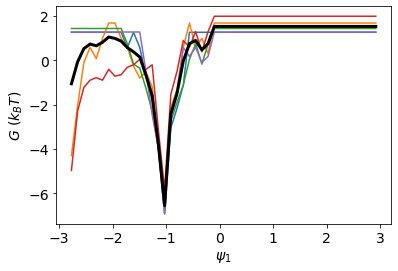

In [88]:
x = np.zeros(len(pmf_LSS_block[0]))
fig, ax = plt.subplots()
for i in range(n_blocks):
    x += pmf_LSS_block[i]/n_blocks
    ax.plot(bin_mids, pmf_LSS_block[i])
im = ax.plot(bin_mids, x, color='black', linewidth=3)
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$G$ ($k_BT$)')
plt.show
print(pmf_LSS_block[1])
pmf_LSS = x

<function matplotlib.pyplot.show(*args, **kw)>

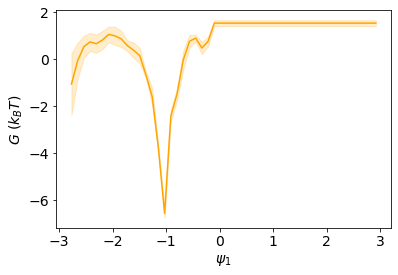

In [89]:
fig, ax = plt.subplots()
ax.plot(bin_mids, pmf_LSS, color='orange')
ax.fill_between(bin_mids, pmf_LSS-pmf_LSS_stderr, pmf_LSS+pmf_LSS_stderr, alpha=0.2, color='orange')
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$G$ ($k_BT$)')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

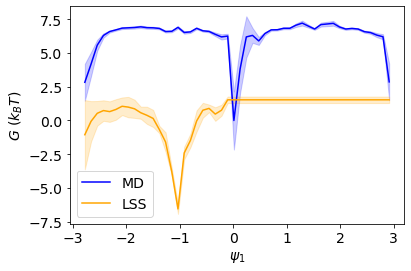

In [90]:
fig, ax = plt.subplots()
ax.plot(bin_mids, pmf_MD, color='blue', label='MD')
ax.fill_between(bin_mids, pmf_MD-1.96*pmf_MD_stderr, pmf_MD+1.96*pmf_MD_stderr, alpha=0.2, color='blue')
ax.plot(bin_mids, pmf_LSS, color='orange', label='LSS')
ax.fill_between(bin_mids, pmf_LSS-1.96*pmf_LSS_stderr, pmf_LSS+1.96*pmf_LSS_stderr, alpha=0.2, color='orange')
plt.xlabel(r'$\psi_1$')
plt.ylabel(r'$G$ ($k_BT$)')
ax.legend()
plt.show

### kinetic (relaxation times)

In [161]:
def compute_autocorr_time(signal, delays):
    ac=[]
    for j in delays:
        if type(signal) is list:
            z = np.concatenate([item[:] for item in signal])
            x = np.concatenate([item[:-j] for item in signal])
            y = np.concatenate([item[j:] for item in signal])
        else:
            z = signal[:]
            x = signal[:-j]
            y = signal[j:]
        ac.append(np.mean(x*y, axis=0)/np.mean(z*z, axis=0))
    return np.array(ac)

In [162]:
# MD mean autocorrelation and implied relaxation time
ac_MD = compute_autocorr_time(hde_coords[:,:dim_prop], [lag_prop])
relax_MD = -lag_prop/np.log(ac_MD)*timestep/1E3

In [163]:
# MD block average standard error estimate
ac_MD_block = []
n_blocks=5
for i in range(n_blocks):
    ac_MD_i = compute_autocorr_time(np.array_split(hde_coords[:,:dim_prop],n_blocks,axis=0)[i], [lag_prop])
    ac_MD_block.append(ac_MD_i)
ac_MD_block = np.array(ac_MD_block)
ac_MD_block = ac_MD_block.reshape(n_blocks,dim_prop)

relax_MD_block = -lag_prop/np.log(ac_MD_block)*timestep/1E3
relax_MD_stderr = np.std(relax_MD_block, axis=0)/np.sqrt(n_blocks)

In [164]:
print('MD relaxation times (ns) = ')
for i in range(relax_MD.shape[1]):
    print('%f +/- %f' % (relax_MD[0,i], relax_MD_stderr[i]))

MD relaxation times (ns) = 
215640.453125 +/- 2095.635986
31040.921875 +/- 18898.607422


In [165]:
# LSS mean autocorrelation and implied relaxation time
ac_LSS = compute_autocorr_time(synth_trajs, [1])
relax_LSS = -lag_prop/np.log(ac_LSS)*timestep/1E3

In [166]:
# LSS block average standard error estimate
# N.B. Blocks in this case are over complete indepenent LSS trajectories since data must be continuous

assert n_traj >= 5 # need at least 5 independent trajectories for reasonable blocks

ac_LSS_block = []
for i in range(n_traj):
    ac_LSS_i = compute_autocorr_time(synth_trajs[i], [1])
    ac_LSS_block.append(ac_LSS_i)
ac_LSS_block = np.array(ac_LSS_block)
ac_LSS_block = ac_LSS_block.reshape(n_traj,synth_trajs[0].shape[1])

relax_LSS_block = -lag_prop/np.log(ac_LSS_block)*timestep/1E3
relax_LSS_stderr = np.std(relax_LSS_block, axis=0)/np.sqrt(n_traj)

In [167]:
print('LSS relaxation times (ns) = ')
for i in range(relax_LSS.shape[1]):
    print('%f +/- %f' % (relax_LSS[0,i], relax_LSS_stderr[i]))

LSS relaxation times (ns) = 
1418.396362 +/- 413.631714
3225.609619 +/- 794.082886


### structure (RMSD)

In [168]:
#xyz_synth = xyz_scaler.inverse_transform(molgen.transform(synth_trajs_scaled[synth_traj_id])).reshape(-1, n_atoms, 3)

In [169]:
def writeToXYZ(xyz_coordinates, filename):
    with open(filename, 'w') as f:
        for i in range(xyz_coordinates.shape[0]):
            f.write('%d\n' % n_atoms)
            f.write('\n')
            for k in range(n_atoms):
                f.write('%3s%17.9f%17.9f%17.9f\n' % ('C', xyz_synth[i][k][0]*10, xyz_synth[i][k][1]*10, xyz_synth[i][k][2]*10) ) # nm to Angstroms for xyz write

                
def xyzToTraj(xyz_coordinates,fn="temp.xyz"):
    writeToXYZ(xyz_coordinates, fn)
    traj = md.load(fn, top='synth.pdb')
    return traj

In [174]:
'''
    ~~~RMSD Calculation~~~
    k = frames where the indexed LSS trajectory is in the metastable basin1
    l = frames where the MD obj trajectory is in the mestable basin1
    
    n = frames where the indexed LSS trajectory is in the metastable basin2
    m = frames where the MD obj trajectory is in the mestable basin2

    t = traj containing all corresponding LSS frames for basin 1
    s = traj containing all corresponding LSS frames for basin 2
    
'''
lowerBasin1 = -0.2
upperBasin1 = 0.2

lowerBasin2 = 1.7
upperBasin2 = 2.3


l = np.where(np.logical_and(hde_coords[:,0]>=lowerBasin1, hde_coords[:,0]<=upperBasin1))
m = np.where(np.logical_and(hde_coords[:,0]>=lowerBasin2, hde_coords[:,0]<=upperBasin2))


for i in range(len(synth_trajs)):
    print("Finding Frames for Traj ",i)
    k = np.where(np.logical_and(synth_trajs[i][:,0]>=lowerBasin1, synth_trajs[0][:,0]<=upperBasin1))
    n = np.where(np.logical_and(synth_trajs[i][:,0]>=lowerBasin2, synth_trajs[0][:,0]<=upperBasin2))
    xyzi = xyz_scaler.inverse_transform(molgen.transform(synth_trajs_scaled[i])).reshape(-1, n_atoms, 3)
    if(i == 0): t = xyzToTraj(xyzi)[k]
    else: t = md.join([t,xyzToTraj(xyzi)[k]])
    if(i == 0): s = xyzToTraj(xyzi)[n]
    else: s = md.join([t,xyzToTraj(xyzi)[n]])

Finding Frames for Traj  0
Finding Frames for Traj  1
Finding Frames for Traj  2
Finding Frames for Traj  3
Finding Frames for Traj  4


In [173]:
rmsd1 = np.mean(md.rmsd(t, traj_ca[l]))
rmsd2 = np.mean(md.rmsd(s, traj_ca[m]))
print("Basin One RMSD is ", rmsd1, " nm. Found ", len(t), "LSS frames in Basin One and ", len(l[0]), " MD frames")
print("Basin Two RMSD is ", rmsd2, " nm. Found ", len(s), "LSS frames in Basin Two and ", len(m[0]), " MD frames")

Basin One RMSD is  nan  nm. Found  0 LSS frames in Basin One and  83115  MD frames
Basin Two RMSD is  0.8854259  nm. Found  1620 LSS frames in Basin Two and  1917  MD frames


In [ ]:
np.where(np.logical_and(hde_coords[:,0]>=lowerBasin2, hde_coords[:,0]<=upperBasin2))